# Project proposal

## Introduction

A heart attack, also known as a myocardial infarction, occurs when blood flow to a part of the heart is blocked, usually by a blood clot. This can cause damage to the heart muscle, which can be life-threatening if not treated promptly. Risk factors for heart attack include smoking, high blood pressure, high cholesterol, obesity, physical inactivity, family history of heart disease, and diabetes. It's important to make lifestyle changes, such as quitting smoking, eating a healthy diet, exercising regularly, and managing any underlying medical conditions, to reduce your risk of heart attack.


Our aim with this project will be to predict using the information in the given dataset to classify the target variable using the KNN model. Our predictive question is whether or not a 28 year old male experiencing atypical angina  with trestbps = 130,chol = 132,thalach = 185, is at a high risk of heart attack or not.

### About the variables of the dataset

**age** : Age of the patient

**sex** : Sex of the patient (0 = female ; 1 = male)

**exang**: exercise induced angina (1 = yes; 0 = no)

**ca**: number of major vessels (0-3) colored by flourosopy

**cp** : Chest Pain type 

* Value 0: typical angina

* Value 1: atypical angina

* Value 2: non-anginal pain

* Value 3: asymptomatic

**trtbps** : resting blood pressure (in mm Hg)

**chol** : cholestoral in mg/dl fetched via BMI sensor

**fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

**rest_ecg** : resting electrocardiographic results

* Value 0: normal

* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

* Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

**thalach** : maximum heart rate achieved

**slope** : the slope of the peak exercise ST segment 
* 0: upsloping
* 1: flat 
* 2: downsloping

**oldpeak** :  ST depression induced by exercise relative to rest

**thal** :   1 = normal; 2 = fixed defect; 3 = reversable defect

**target** : 0 = less chance of heart attack ,  1 = more chance of heart attack

Unknown data :

age: 28;
sex: 1;
cp: 2;
trestbps: 130;
chol :132;
fbs: 0;
restecg:2;
thalach: 185;
exang: 0;
oldpeak: 0.0;
thal : 2;
slope : 2;
ca: 0;
target = ?

In [ ]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



1. age: age in years      
2. sex: 
<br><font color = "yellowgreen">1: male<br> 0: female</font>  
3. cp: chest pain type 
<br><font color = "yellowgreen">1: typical angina<br> 2: atypical angina<br> 3: non-anginal pain<br> 4: asymptomatic</font> 
4. trestbps: resting blood pressure in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl    
6. fbs: fasting blood sugar
<br><font color = "yellowgreen">1: >120mg/dl<br> 2: ≤120mg/dl</font>  
7. restecg: resting electrocardiographic results
<br><font color = "yellowgreen">0: normal<br> 1: having ST-T wave abnormality<br> 2: showing probable or definite left ventricular hypertrophy by Estes' criteria</font>  
8. thalach: duration of exercise test in minutes
9. exang: exercise induced angina
<br><font color = "yellowgreen">1: yes<br> 2: no</font> 
10. oldpeak: ST depression induced by exercise relative to rest   
11. slope: the slope of the peak exercise ST segment
<br><font color = "yellowgreen">1: upsloping<br> 2: flat <br> 3: downsloping</font> 
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 
<br><font color = "yellowgreen">3: normal<br> 6: fixed defect <br> 7: reversable defect</font> 
14. num: diagnosis of heart disease (angiographic disease status)
<br><font color = "yellowgreen">0: &lt; 50% diameter narrowing <br> 1: &gt; 50% diameter narrowing</font> 

## Preliminary exploratory data analysis:

In [58]:
heart_data <- read_csv("heart.csv")
heart_data

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


In [5]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
heart_data <- read_csv("heart.csv")
head(heart_data)
#heart_data1 <- read_csv("processed.hungarian.data",col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"))
#heart_data1
#filtered <- filter(heart_data1, thal == "?")
#filtered

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


### Selecting only intrested columns from data set

In [ ]:
heart_data_1 <- select(heart_data,age,cp,trestbps,chol,thalach,oldpeak) |> mutate(cp = as_factor(cp))
heart_data_1

<<<<<<< local <modified: text/html, text/latex, text/markdown, text/plain>


trestbps,chol,thalach,cp,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,212,168,0,0
140,203,155,0,0
145,174,125,0,0
148,203,161,0,0
138,294,106,0,0
100,248,122,0,1
114,318,140,0,0
160,289,145,0,0
120,249,144,0,0


age,cp,trestbps,chol,thalach,oldpeak,target
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,0,125,212,168,1.0,0
53,0,140,203,155,3.1,0
70,0,145,174,125,2.6,0
61,0,148,203,161,0.0,0
62,0,138,294,106,1.9,0
58,0,100,248,122,1.0,1
58,0,114,318,140,4.4,0
55,0,160,289,145,0.8,0
46,0,120,249,144,0.8,0


>>>>>>> remote <modified: text/html, text/latex, text/markdown, text/plain>


### Plotting graphs of all variables and coloring them by the target variable

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



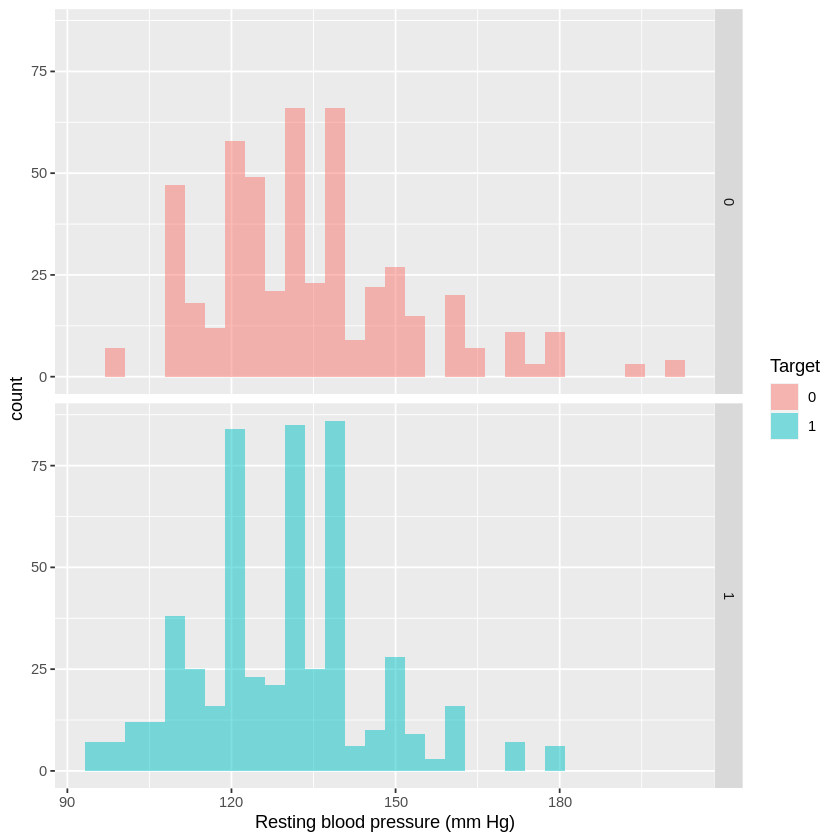

In [60]:
trestbps_plot <- ggplot(heart_data_1, aes(x = trestbps, fill = as_factor(target))) + geom_histogram(alpha = 0.5, position = "identity") + facet_grid(rows = vars(target))+labs(x = "Resting blood pressure (mm Hg)",fill = "Target")
trestbps_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



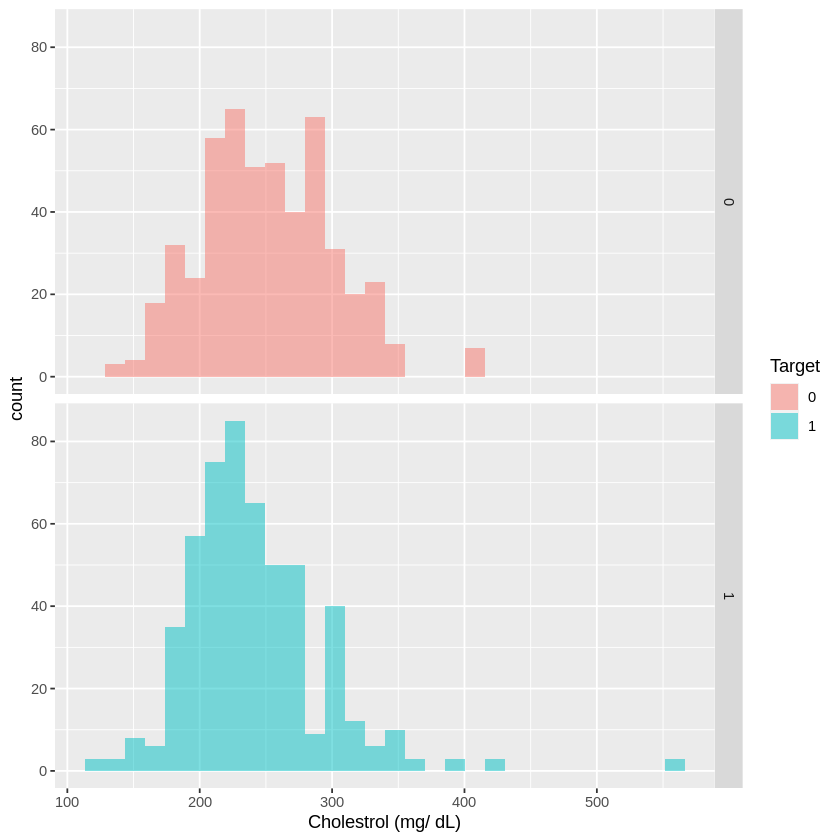

In [61]:
chol_plot <- ggplot(heart_data_1, aes(x = chol, fill = as_factor(target))) + geom_histogram(alpha = 0.5, position = "identity") + facet_grid(rows = vars(target))+labs(x = "Cholestrol (mg/ dL)",fill = "Target")
chol_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



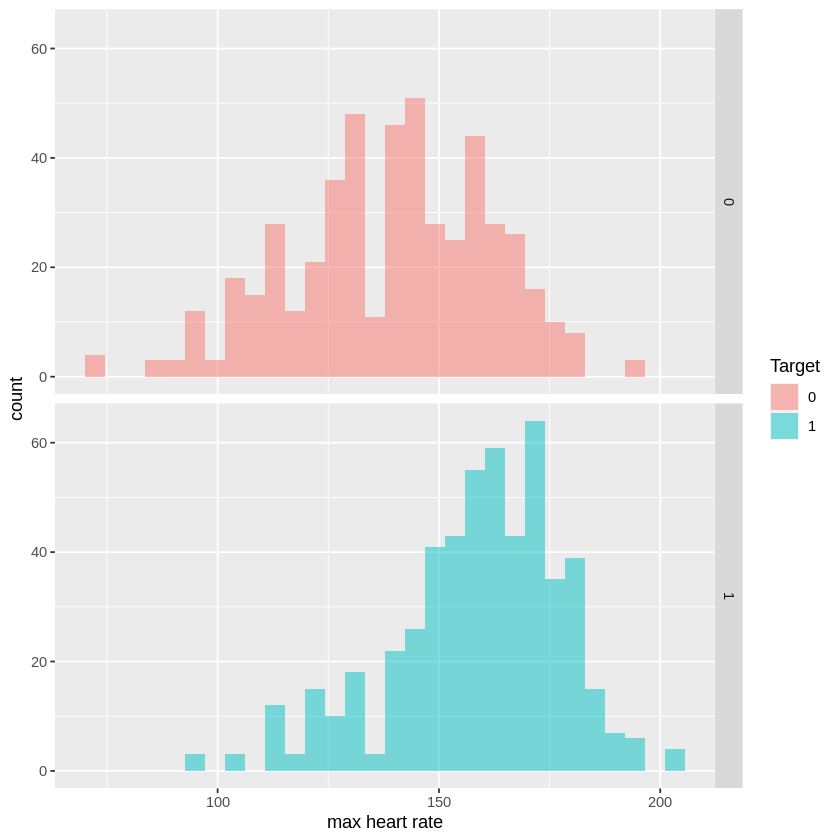

In [62]:
thalach_plot <- ggplot(heart_data_1, aes(x = thalach, fill = as_factor(target))) + geom_histogram(alpha = 0.5, position = "identity") + facet_grid(rows = vars(target)) + labs(x = "max heart rate",fill = "Target")
thalach_plot

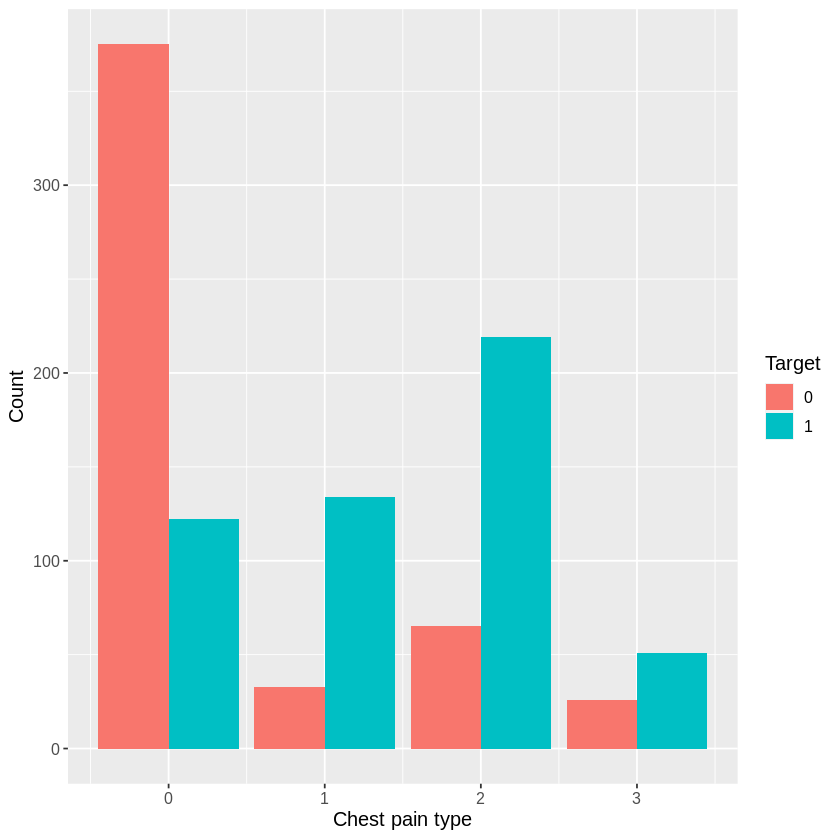

In [63]:
trestbps_plot <- ggplot(heart_data_1, 
                      aes(x = cp,
                          fill = target)) +
  geom_bar(position = "dodge") +
  labs(x = "Chest pain type", y = "Count",  fill = "Target") +
  theme(text = element_text(size = 12))
trestbps_plot

## Summary table

In [64]:
summary_table <- heart_data_1 |>
    group_by(target) |>
    summarize(mean_trestbps= mean(trestbps,na.rm = TRUE),mean_chol= mean(chol,na.rm = TRUE),mean_thalach= mean(thalach,na.rm = TRUE),median_cp = median(cp,na.rm = TRUE), count = n())
summary_table

target,mean_trestbps,mean_chol,mean_thalach,median_cp,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,134.1062,251.2926,139.1303,0,499
1,129.2452,240.9791,158.5856,2,526


In [65]:
missing_table <- data.frame(Column_Names = colnames(heart_data), 
                            Missing_Values = colSums(is.na(heart_data)))
missing_table

,Column_Names,Missing_Values
,<chr>,<dbl>
age,age,0
sex,sex,0
cp,cp,0
trestbps,trestbps,0
chol,chol,0
fbs,fbs,0
restecg,restecg,0
thalach,thalach,0
exang,exang,0


Turns out that we dont have any null or missing values in the dataset